In [24]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklea

In [40]:

import numpy as np 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import FeatureUnion, Pipeline 

#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    #Return self nothing else to do here    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ] 

In [2]:
os.chdir(r'C:\Users\Kazi\Desktop\Python Development\New Dev')

In [97]:
X=pd.read_csv(r'.\housesalesprediction\kc_house_data.csv')

In [17]:
house_data.drop(house_data.select_dtypes(['object']),inplace=True,axis=1)


In [20]:
house_data.drop(['id'],inplace=True,axis=1)

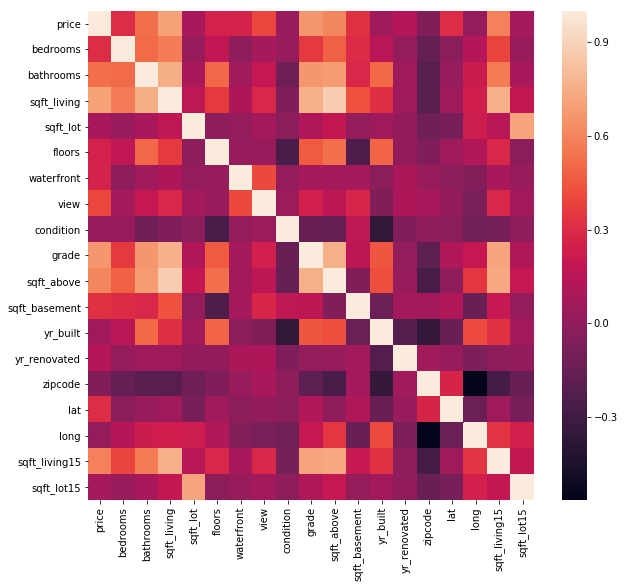

In [26]:
plt.figure(figsize=(10,9))
sns.heatmap(house_data.corr())

In [120]:
# class CategoricalTransformer(BaseEstimator, TransformerMixin):
#     def __init__(self,use_dates=['year','month','day']):
#         self.__use_dates = use_dates
#         print(self.__use_dates)
    
#     def fit(self,X,y=None):
#         return self
    
#     def get_year(self,obj):
#         return str(obj)[:4]
    
#     def get_month(self,obj):
#         return str(obj)[4:6]
    
#     def get_day(self,obj):
#         return str(obj)[6:8]
    
#     def create_binary(self,obj):
#         if obj==0:
#             return 'No'
#         else:
#             return 'Yes'
        
#     def transform(self,X,y=None):
#         for spec in self.__use_dates:
#             exec( "X.loc[:,'{}'] = X['date'].apply(self.get_{})".format( spec, spec ) )
#        #Drop unusable column 
#         X = X.drop('date', axis = 1 )
            
#         X.loc[:,'waterfront']= X['waterfront'].apply(self.create_binary)
        
#         X.loc[:,'view']=X['view'].apply(self.create_binary)
        
#         X.loc[:,'yr_renovated'] = X['yr_renovated'].apply(self.create_binary)
        
#         return X.values

In [162]:

#Custom transformer that breaks dates column into year, month and day into separate columns and
#converts certain features to binary 
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    #Class constructor method that takes in a list of values as its argument
    def __init__(self, use_dates = ['year', 'month', 'day'] ):
        self._use_dates = use_dates
        
    #Return self nothing else to do here
    def fit( self, X, y = None  ):
        return self

    #Helper function to extract year from column 'dates' 
    def get_year( self, obj ):
        return str(obj)[:4]
    
    #Helper function to extract month from column 'dates'
    def get_month( self, obj ):
        return str(obj)[4:6]
    
    #Helper function to extract day from column 'dates'
    def get_day(self, obj):
        return str(obj)[6:8]
    
    #Helper function that converts values to Binary depending on input 
    def create_binary(self, obj):
        if obj == 0:
            return 'No'
        else:
            return 'Yes'
    
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
       #Depending on constructor argument break dates column into specified units
       #using the helper functions written above 
           for spec in self._use_dates:
                if spec=='year':
                    X.loc[:,'year'] = X['date'].apply(self.get_year)
                elif spec=='month':
                    X.loc[:,'month'] = X['month'].apply(self.get_year)
                elif spec=='day':
                    X.loc[:,'day'] = X['day'].apply(self.get_year)
           #Drop unusable column 
           X.loc[:,'year'] = X['date'].apply(self.get_year)
           X = X.drop('date', axis = 1 )

           #Convert these columns to binary for one-hot-encoding later
           X.loc[:,'waterfront'] = X['waterfront'].apply( self.create_binary )

           X.loc[:,'view'] = X['view'].apply( self.create_binary )

           X.loc[:,'yr_renovated'] = X['yr_renovated'].apply( self.create_binary )
           #returns numpy array
           return X.values 

In [126]:

#Custom transformer we wrote to engineer features ( bathrooms per bedroom and/or how old the house is in 2019  ) 
#passed as boolen arguements to its constructor
class NumericalTransformer(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__( self, bath_per_bed = True, years_old = True ):
        self._bath_per_bed = bath_per_bed
        self._years_old = years_old
        
    #Return self, nothing else to do here
    def fit( self, X, y = None ):
        return self 
    
    #Custom transform method we wrote that creates aformentioned features and drops redundant ones 
    def transform(self, X, y = None):
        #Check if needed 
        if self._bath_per_bed:
            #create new column
            X.loc[:,'bath_per_bed'] = X['bathrooms'] / X['bedrooms']
            #drop redundant column
            X.drop('bathrooms', axis = 1 )
        #Check if needed     
        if self._years_old:
            #create new column
            X.loc[:,'years_old'] =  2019 - X['yr_built']
            #drop redundant column 
            X.drop('yr_built', axis = 1)
            
        #Converting any infinity values in the dataset to Nan
        X = X.replace( [ np.inf, -np.inf ], np.nan )
        #returns a numpy array
        return X.values

In [127]:

#Categrical features to pass down the categorical pipeline 
categorical_features = ['date', 'waterfront', 'view', 'yr_renovated']

#Numerical features to pass down the numerical pipeline 
numerical_features = ['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
                'condition', 'grade', 'sqft_basement', 'yr_built']

#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features) ),
                                  
                                  ( 'cat_transformer', CategoricalTransformer() ), 
                                  
                                  ( 'one_hot_encoder', OneHotEncoder( sparse = False ) ) ] )
    
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(numerical_features) ),
                                  
                                  ( 'num_transformer', NumericalTransformer() ),
                                  
                                  ('imputer', SimpleImputer(strategy = 'median') ),
                                  
                                  ( 'std_scaler', StandardScaler() ) ] )

#Combining numerical and categorical piepline into one full big pipeline horizontally 
#using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                                  
                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )

In [163]:

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

#Leave it as a dataframe becuase our pipeline is called on a 
#pandas dataframe to extract the appropriate columns, remember?
X = data.drop('price', axis = 1)
#You can covert the target variable to numpy 
y = data['price'].values 

X_train, X_test, y_train, y_test = train_test_split( X, y , test_size = 0.2 , random_state = 42 )

#The full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_m = Pipeline( steps = [ ( 'full_pipeline', full_pipeline),
                                  
                                  ( 'model', LinearRegression() ) ] )

#Can call fit on it just like any other pipeline
full_pipeline_m.fit( X_train, y_train )

#Can predict with it like any other pipeline
y_pred = full_pipeline_m.predict( X_test ) 

C:\Users\Kazi\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Kazi\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Kazi\Anaconda3\lib\site-packages\pandas\core\indexing.py:357: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documenta

In [167]:
from sklearn import metrics
metrics.r2_score(y_pred,y_test)

0.4457304769574515

In [165]:
exec("X.loc[:,'{}']".format('bedrooms'))

TypeError: 'str' object is not callable

In [34]:
import pandas as pd
import re
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
pd.set_option('display.max_columns',60)

In [87]:
import pandas as pd
import re
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
pd.set_option('display.max_columns',60)

In [51]:
Loan_copy.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,url,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,...,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,42535.000000,42535.000000,42535.000000,42535.000000,4.253100e+04,0.0,42535.000000,42506.000000,42506.000000,15609.000000,3651.000000,42506.000000,42506.000000,4.253500e+04,42506.000000,42535.0,42535.0,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42535.000000,42390.0,0.0,42535.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,160.000000,160.000000,160.000000
mean,NaN,11089.722581,10821.585753,10139.938785,322.623063,6.913656e+04,NaN,13.373043,0.152449,1.081424,35.017618,59.175568,9.343951,0.058156,1.429786e+04,22.124406,0.0,0.0,12020.373444,11312.912629,9675.675936,2239.981444,1.516890,103.199267,14.420927,2613.245652,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4270.794250,49.889875,1.262500
std,NaN,7410.938391,7146.914675,7131.598014,208.927216,6.409635e+04,NaN,6.726315,0.512406,1.527455,22.418427,47.145396,4.496274,0.245713,2.201844e+04,11.592811,0.0,0.0,9094.837244,9038.609652,7105.750304,2585.057393,7.830064,736.777540,162.317803,4385.066535,0.0,NaN,0.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3119.543917,15.569143,4.142869
min,NaN,500.000000,500.000000,0.000000,15.670000,1.896000e+03,NaN,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000e+00,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,193.290000,10.690000,0.000000
25%,NaN,5200.000000,5000.000000,4950.000000,165.520000,4.000000e+04,NaN,8.200000,0.000000,0.000000,17.000000,0.000000,6.000000,0.000000,3.635000e+03,13.000000,0.0,0.0,5465.685189,4793.115000,4400.000000,657.100000,0.000000,0.000000,0.000000,211.050000,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1842.750000,40.000000,0.000000
50%,NaN,9700.000000,9600.000000,8500.000000,277.690000,5.900000e+04,NaN,13.470000,0.000000,1.000000,33.000000,85.000000,9.000000,0.000000,8.821000e+03,20.000000,0.0,0.0,9682.251696,8956.080000,8000.000000,1339.160000,0.000000,0.000000,0.000000,528.360000,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3499.350000,49.970000,0.000000
75%,NaN,15000.000000,15000.000000,14000.000000,428.180000,8.250000e+04,NaN,18.680000,0.000000,2.000000,51.000000,101.000000,12.000000,0.000000,1.725100e+04,29.000000,0.0,0.0,16427.850066,15544.335000,13499.995000,2803.090000,0.000000,0.000000,0.000000,3170.220000,0.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [75]:


class DataTransformer(BaseEstimator,TransformerMixin):
    
    def __init__(self):
        pass
    
    def fit(self,X,y=None):
        return self
    
    def get_numbers(self,X):
            return float(re.findall(r'[0-9]+',X)[0])
    
    def binary_converted(self,X):
        if X=="Fully Paid":
            return 0
        else:
            return 1
    
    def transform(self,X,y=None):
        selected_features= ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries','home_ownership',
       'collection_recovery_fee', 'last_pymnt_amnt','grade','issue_d']
        X=X[selected_features]
#         X=X[(X['loan_status']!="Does not meet the credit policy. Status:Fully Paid" )&(X['loan_status']!="Does not meet the credit policy. Status:Charged Off")]
#         X['loan_status'] = X['loan_status'].apply(self.binary_converted)
        X=X[~X['issue_d'].isnull()]
        X['issue_d']=X['issue_d'].apply(self.get_numbers)
        X=X.join(pd.get_dummies(X['home_ownership']))
        X.drop('home_ownership',axis=1,inplace=True)
        X['emp_length'] =['0' if len=="< 1 year" else len for len in X['emp_length']]
        X=X[~X['emp_length'].isnull()]
        X['emp_length'] = X['emp_length'].apply(self.get_numbers)
        X['int_rate'] = X['int_rate'].apply(self.get_numbers)
        X=X.join(pd.get_dummies(X.grade))
        X.drop('grade',axis=1,inplace=True)
        X.dropna(inplace=True)
        return X.values

In [6]:
Loan_copy=pd.read_csv(r'E:\personal_kazi\bajaj_finserv\LoanStats3a.csv\LoanStats3a.csv',skiprows=1)

C:\Users\Kazi\AppData\Roaming\Python\Python36\site-packages\IPython\core\interactiveshell.py:3044: DtypeWarning: Columns (0,47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [92]:
Loan_copy=Loan_copy[(Loan_copy['loan_status']!="Does not meet the credit policy. Status:Fully Paid" )&(Loan_copy['loan_status']!="Does not meet the credit policy. Status:Charged Off")]
Loan_copy['loan_status'] = Loan_copy['loan_status'].apply(DataTransformer().binary_converted)

C:\Users\Kazi\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [215]:
final_data = pd.read_pickle(r'C:\Users\Kazi\Desktop\Python Development\New Dev\Loan_Stat_ml_2.pickle')
final_data.columns

Index(['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'loan_status', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'MORTGAGE', 'NONE',
       'OTHER', 'OWN', 'RENT', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'issue_d'],
      dtype='object')

In [14]:
        selected_features= ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'int_rate',
       'installment', 'emp_length', 'annual_inc', 'loan_status', 'dti',
       'delinq_2yrs', 'inq_last_6mths', 'open_acc', 'pub_rec', 'revol_bal',
       'total_acc', 'total_pymnt', 'total_pymnt_inv', 'total_rec_prncp',
       'total_rec_int', 'total_rec_late_fee', 'recoveries','home_ownership',
       'collection_recovery_fee', 'last_pymnt_amnt','grade','issue_d']

In [70]:
dt=DataTransformer()
pass_=pd.DataFrame(dt.transform(Loan_copy))
# Pipeline(steps)
pass_.dropna(inplace=True)
pass_.isnull().any()
# pass_.join(pd.get_dummies(pass_.grade))

loan_amnt                  False
funded_amnt                False
funded_amnt_inv            False
int_rate                   False
installment                False
emp_length                 False
annual_inc                 False
dti                        False
delinq_2yrs                False
inq_last_6mths             False
open_acc                   False
pub_rec                    False
revol_bal                  False
total_acc                  False
total_pymnt                False
total_pymnt_inv            False
total_rec_prncp            False
total_rec_int              False
total_rec_late_fee         False
recoveries                 False
collection_recovery_fee    False
last_pymnt_amnt            False
issue_d                    False
MORTGAGE                   False
NONE                       False
OTHER                      False
OWN                        False
RENT                       False
A                          False
B                          False
C         

In [17]:
DataTransformer().fit_transform(X=Loan_copy)

array([[5000.0, 5000.0, 4975.0, ..., 0, 0, 1],
       [2500.0, 2500.0, 2500.0, ..., 0, 0, 1],
       [2400.0, 2400.0, 2400.0, ..., 0, 0, 1],
       ...,
       [5000.0, 5000.0, 1325.0, ..., 0, 0, 0],
       [5000.0, 5000.0, 650.0, ..., 0, 0, 0],
       [7500.0, 7500.0, 800.0, ..., 0, 1, 0]], dtype=object)

In [ ]:
full_pipeline_m = Pipeline( steps = [ ( 'full_pipeline', full_pipeline),
                                  
                                  ( 'model', LinearRegression() ) ] )

In [88]:
pipeline = Pipeline(steps=
                   [('data transformation', DataTransformer()),
                    ('standard scaler',StandardScaler()),
                    ('log reg',LogisticRegression())
                   ]
                   )

In [100]:
pipeline.fit(Loan_copy,Loan_copy['loan_status'].iloc[:38708].values)

C:\Users\Kazi\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('data transformation', DataTransformer()),
                ('standard scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('log reg',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [101]:
pipeline.predict(Loan_copy)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [86]:
pipeline.transform(Loan_copy)

array([[-0.83106426, -0.82383742, -0.73122125, ..., -0.29645297,
        -0.17855905, -0.11168848],
       [-1.16817604, -1.17337412, -1.07773619, ..., -0.29645297,
        -0.17855905, -0.11168848],
       [-1.18166052, -1.18735559, -1.0917368 , ..., -0.29645297,
        -0.17855905, -0.11168848],
       ...,
       [-1.2355984 , -1.24328146, -1.24924359, ..., -0.29645297,
        -0.17855905, -0.11168848],
       [-0.69621955, -0.68402274, -1.33674736, ..., -0.29645297,
        -0.17855905, -0.11168848],
       [-0.91197109, -0.90772623, -1.23174283, ..., -0.29645297,
        -0.17855905, -0.11168848]])